In [2]:
from re import I
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

- train_iter内包含的内容有tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,mlm_Y, nsp_y
- 其实这一部分反而是目前为止最好理解的部分，基本所以内容和之前区别不大了

原始BERT有两个不同模型尺寸的版本。基本模型（$\text{BERT}_{\text{BASE}}$）使用12层（Transformer编码器块），768个隐藏单元（隐藏大小）和12个自注意头。大模型（$\text{BERT}_{\text{LARGE}}$）使用24层，1024个隐藏单元和16个自注意头。值得注意的是，前者有1.1亿个参数，后者有3.4亿个参数。为了便于演示，我们定义了一个小的BERT，使用了2层、128个隐藏单元和2个自注意头。

In [4]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=4,
                    num_layers=4, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
#net返回的为 encoded_X, mlm_Y_hat, nsp_Y_hat
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

在定义训练代码实现之前，我们定义了一个辅助函数_get_batch_loss_bert。给定训练样本，该函数计算遮蔽语言模型和下一句子预测任务的损失。请注意，BERT预训练的最终损失是遮蔽语言模型损失和下一句预测损失的和。

In [5]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # 前向传播
    # 预训练不需要encoder的输出
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [6]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    # 多GPU实现
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    # 这里没有使用epoch，而是训练一定步数的batch后停止
    while step < num_steps and not num_steps_reached:
        # 这里就是之前定义的，参数返回，看69 07就好了
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            # 数据加载到GPU 
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            # 自定义的损失函数
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

MLM loss 5.395, NSP loss 0.701
9033.4 sentence pairs/sec on [device(type='cuda', index=0)]


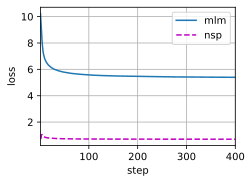

In [7]:
train_bert(train_iter, net, loss, len(vocab), devices, 400)

在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。下面的函数返回tokens_a和tokens_b中所有词元的BERT（net）表示。

这里相信看完前面的word2vec，再来理解这个预训练，会很好理解，其实就是bert版本的embedding，这里对应的就是encoded_X

In [8]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

考虑“a crane is flying”这句话。回想一下BERT的输入表示。插入特殊标记“$<cls>$”（用于分类）和“$<sep>$”（用于分隔）后，BERT输入序列的长度为6。因为零是“$<cls>$”词元，encoded_text[:, 0, :]是整个输入语句的BERT表示。为了评估一词多义词元“crane”，我们还打印出了该词元的BERT表示的前三个元素。

In [9]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([ 1.2281,  1.6948, -2.4672], device='cuda:0', grad_fn=<SliceBackward0>))

现在考虑一个句子“a crane driver came”和“he just left”。类似地，encoded_pair[:, 0, :]是来自预训练BERT的整个句子对的编码结果。注意，多义词元“crane”的前三个元素与上下文不同时的元素不同。这支持了BERT表示是上下文敏感的。

In [10]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just',
# 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([ 1.2409,  0.0748, -2.5067], device='cuda:0', grad_fn=<SliceBackward0>))

In [11]:
tokens_a, tokens_b = ['b', 'crane', 'driver', 'came'], ['she', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just',
# 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([ 1.2504,  1.7478, -2.4956], device='cuda:0', grad_fn=<SliceBackward0>))